<a href="https://colab.research.google.com/github/fhdbbk/fastai-1/blob/main/05_multicat.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#hide
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

     |████████████████████████████████| 720 kB 5.0 MB/s 
     |████████████████████████████████| 189 kB 55.5 MB/s 
     |████████████████████████████████| 1.2 MB 45.9 MB/s 
     |████████████████████████████████| 46 kB 4.3 MB/s 
     |████████████████████████████████| 56 kB 1.3 MB/s 
     |████████████████████████████████| 51 kB 218 kB/s 
Mounted at /content/gdrive


In [2]:
#hide
from fastbook import *

# Other Computer Vision Problems

## Multi-Label Classification

### The Data

In [3]:
from fastai.vision.all import *
path = untar_data(URLs.PASCAL_2007)

In [4]:
URLs.PASCAL_2007

'https://s3.amazonaws.com/fast-ai-imagelocal/pascal_2007.tgz'

In [5]:
path.ls()

(#8) [Path('/root/.fastai/data/pascal_2007/segmentation'),Path('/root/.fastai/data/pascal_2007/valid.json'),Path('/root/.fastai/data/pascal_2007/train.csv'),Path('/root/.fastai/data/pascal_2007/test'),Path('/root/.fastai/data/pascal_2007/train.json'),Path('/root/.fastai/data/pascal_2007/train'),Path('/root/.fastai/data/pascal_2007/test.json'),Path('/root/.fastai/data/pascal_2007/test.csv')]

In [6]:
df = pd.read_csv(path/'train.csv')
df.head()

,fname,labels,is_valid
0,000005.jpg,chair,True
1,000007.jpg,car,True
2,000009.jpg,horse person,True
3,000012.jpg,car,False
4,000016.jpg,bicycle,True


### Sidebar: Pandas and DataFrames

In [7]:
df.iloc[:,0]

0       000005.jpg
1       000007.jpg
2       000009.jpg
3       000012.jpg
4       000016.jpg
           ...    
5006    009954.jpg
5007    009955.jpg
5008    009958.jpg
5009    009959.jpg
5010    009961.jpg
Name: fname, Length: 5011, dtype: object

In [8]:
df.iloc[0,:]
# Trailing :s are always optional (in numpy, pytorch, pandas, etc.),
#   so this is equivalent:
df.iloc[0]

fname       000005.jpg
labels           chair
is_valid          True
Name: 0, dtype: object

In [9]:
df['fname']

0       000005.jpg
1       000007.jpg
2       000009.jpg
3       000012.jpg
4       000016.jpg
           ...    
5006    009954.jpg
5007    009955.jpg
5008    009958.jpg
5009    009959.jpg
5010    009961.jpg
Name: fname, Length: 5011, dtype: object

In [10]:
tmp_df = pd.DataFrame({'a':[1,2], 'b':[3,4]})
tmp_df

,a,b
0,1,3
1,2,4


In [11]:
tmp_df['c'] = tmp_df['a']+tmp_df['b']
tmp_df

,a,b,c
0,1,3,4
1,2,4,6


### End sidebar

### Constructing a DataBlock

* A dataset is a collection that returns a tuple of our independent and dependent variable for a single item. We can also take the length of it.
* A dataloader is an iterator that provides a stream of mini-batches, where each mini-batch is a couple of a batch of independent variables and a batch of dependent variables.

In [12]:
# Example dataset
a = list(enumerate(string.ascii_lowercase))
print(a[0])
print(len(a))

(0, 'a')
26


Now we have a dataset, so we can pass it to a dataloader

In [13]:
dl_a = DataLoader(a, batch_size=8, shuffle=True)
b = first(dl_a)
b

(tensor([ 7, 24, 17, 21,  5, 19,  9, 15]),
 ('h', 'y', 'r', 'v', 'f', 't', 'j', 'p'))

**Datasets:** An iterator that contains a training Dataset and a validation Dataset.

**DataLoaders:** An object that contains a training DataLoader and a validation DataLoader.

In [14]:
a = list(string.ascii_lowercase)
print(a[0])
print(len(a))

a
26


In [21]:
dss = Datasets(a)
print(dss.train)
print(dss.valid)
print(dss.train[0])

(#26) [('a',),('b',),('c',),('d',),('e',),('f',),('g',),('h',),('i',),('j',)...]
(#0) []
('a',)


In [22]:
def f1(o): return o + 'a'
def f2(o): return o + 'b'

In [23]:
dss = Datasets(a, tfms=[[f1]])
dss[0]

('aa',)

In [24]:
dss = Datasets(a, tfms=[[f1, f2]])
dss[0]

('aab',)

In [26]:
# This is the way we generally create a dataset wherein we pass a filename and 
# apply two functions to it. One returns the image and another return the label. 
# Thus we get a tuple of image and label.
dss = Datasets(a, tfms=[[f1], [f2]])
dss[0]

('aa', 'ab')

In [27]:
dls = DataLoaders.from_dsets(dss, batch_size=4)
first(dls.train)

(('ra', 'sa', 'ka', 'wa'), ('rb', 'sb', 'kb', 'wb'))

Creating datasets and dataloaders using Datablock

In [28]:
dblock = DataBlock()

In [29]:
dsets = dblock.datasets(df)

In [30]:
len(dsets.train),len(dsets.valid)

(4009, 1002)

In [31]:
x,y = dsets.train[0]
x,y

(fname         002786.jpg
 labels      horse person
 is_valid            True
 Name: 1401, dtype: object, fname         002786.jpg
 labels      horse person
 is_valid            True
 Name: 1401, dtype: object)

This simply returns a row of the DataFrame, twice. This is because by
default, the data block assumes we have two things: input and target. We are going to need to grab the appropriate fields from the DataFrame, which we can do by passing get_x and get_y functions

In [32]:
x['fname']

'002786.jpg'

In [33]:
dblock = DataBlock(get_x = lambda r: r['fname'], get_y = lambda r: r['labels'])
dsets = dblock.datasets(df)
dsets.train[0]

('007204.jpg', 'cat')

In [34]:
def get_x(r): return r['fname']
def get_y(r): return r['labels']
dblock = DataBlock(get_x = get_x, get_y = get_y)
dsets = dblock.datasets(df)
dsets.train[0]

('002848.jpg', 'motorbike')

In [35]:
def get_x(r): return path/'train'/r['fname']
def get_y(r): return r['labels'].split(' ')
dblock = DataBlock(get_x = get_x, get_y = get_y)
dsets = dblock.datasets(df)
dsets.train[0]

(Path('/root/.fastai/data/pascal_2007/train/004010.jpg'), ['sofa', 'person'])

In [36]:
dblock = DataBlock(blocks=(ImageBlock, MultiCategoryBlock),
                   get_x = get_x, get_y = get_y)
dsets = dblock.datasets(df)
dsets.train[0]

(PILImage mode=RGB size=500x375,
 TensorMultiCategory([0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]))

In [40]:
torch.where(dsets.train[0][1] == 1)[0]

TensorMultiCategory([ 6, 14])

In [42]:
idxs = torch.where(dsets.train[0][1]==1.)[0]
print(idxs)
dsets.train.vocab[idxs]

TensorMultiCategory([ 6, 14])


(#2) ['car','person']

In [47]:
df.index[~df['is_valid']].tolist()[:10]

[3, 5, 9, 11, 13, 14, 15, 16, 17, 20]

In [48]:
def splitter(df):
    train = df.index[~df['is_valid']].tolist()
    valid = df.index[df['is_valid']].tolist()
    return train,valid

dblock = DataBlock(blocks=(ImageBlock, MultiCategoryBlock),
                   splitter=splitter,
                   get_x=get_x, 
                   get_y=get_y)

dsets = dblock.datasets(df)
dsets.train[0]

(PILImage mode=RGB size=500x333,
 TensorMultiCategory([0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]))

In [49]:
dblock = DataBlock(blocks=(ImageBlock, MultiCategoryBlock),
                   splitter=splitter,
                   get_x=get_x, 
                   get_y=get_y,
                   item_tfms = RandomResizedCrop(128, min_scale=0.35))
dls = dblock.dataloaders(df)

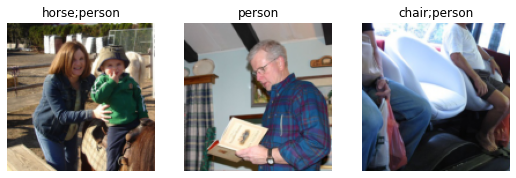

In [50]:
dls.show_batch(nrows=1, ncols=3)

### Binary Cross-Entropy

In [ ]:
learn = cnn_learner(dls, resnet18)

In [ ]:
x,y = to_cpu(dls.train.one_batch())
activs = learn.model(x)
activs.shape

In [ ]:
activs[0]

In [ ]:
def binary_cross_entropy(inputs, targets):
    inputs = inputs.sigmoid()
    return -torch.where(targets==1, inputs, 1-inputs).log().mean()

In [ ]:
loss_func = nn.BCEWithLogitsLoss()
loss = loss_func(activs, y)
loss

In [ ]:
def say_hello(name, say_what="Hello"): return f"{say_what} {name}."
say_hello('Jeremy'),say_hello('Jeremy', 'Ahoy!')

In [ ]:
f = partial(say_hello, say_what="Bonjour")
f("Jeremy"),f("Sylvain")

In [ ]:
learn = cnn_learner(dls, resnet50, metrics=partial(accuracy_multi, thresh=0.2))
learn.fine_tune(3, base_lr=3e-3, freeze_epochs=4)

In [ ]:
learn.metrics = partial(accuracy_multi, thresh=0.1)
learn.validate()

In [ ]:
learn.metrics = partial(accuracy_multi, thresh=0.99)
learn.validate()

In [ ]:
preds,targs = learn.get_preds()

In [ ]:
accuracy_multi(preds, targs, thresh=0.9, sigmoid=False)

In [ ]:
xs = torch.linspace(0.05,0.95,29)
accs = [accuracy_multi(preds, targs, thresh=i, sigmoid=False) for i in xs]
plt.plot(xs,accs);

## Regression

### Assemble the Data

In [ ]:
path = untar_data(URLs.BIWI_HEAD_POSE)

In [ ]:
#hide
Path.BASE_PATH = path

In [ ]:
path.ls().sorted()

In [ ]:
(path/'01').ls().sorted()

In [ ]:
img_files = get_image_files(path)
def img2pose(x): return Path(f'{str(x)[:-7]}pose.txt')
img2pose(img_files[0])

In [ ]:
im = PILImage.create(img_files[0])
im.shape

In [ ]:
im.to_thumb(160)

In [ ]:
cal = np.genfromtxt(path/'01'/'rgb.cal', skip_footer=6)
def get_ctr(f):
    ctr = np.genfromtxt(img2pose(f), skip_header=3)
    c1 = ctr[0] * cal[0][0]/ctr[2] + cal[0][2]
    c2 = ctr[1] * cal[1][1]/ctr[2] + cal[1][2]
    return tensor([c1,c2])

In [ ]:
get_ctr(img_files[0])

In [ ]:
biwi = DataBlock(
    blocks=(ImageBlock, PointBlock),
    get_items=get_image_files,
    get_y=get_ctr,
    splitter=FuncSplitter(lambda o: o.parent.name=='13'),
    batch_tfms=[*aug_transforms(size=(240,320)), 
                Normalize.from_stats(*imagenet_stats)]
)

In [ ]:
dls = biwi.dataloaders(path)
dls.show_batch(max_n=9, figsize=(8,6))

In [ ]:
xb,yb = dls.one_batch()
xb.shape,yb.shape

In [ ]:
yb[0]

### Training a Model

In [ ]:
learn = cnn_learner(dls, resnet18, y_range=(-1,1))

In [ ]:
def sigmoid_range(x, lo, hi): return torch.sigmoid(x) * (hi-lo) + lo

In [ ]:
plot_function(partial(sigmoid_range,lo=-1,hi=1), min=-4, max=4)

In [ ]:
dls.loss_func

In [ ]:
learn.lr_find()

In [ ]:
lr = 1e-2
learn.fine_tune(3, lr)

In [ ]:
math.sqrt(0.0001)

In [ ]:
learn.show_results(ds_idx=1, nrows=3, figsize=(6,8))

## Conclusion

## Questionnaire

1. How could multi-label classification improve the usability of the bear classifier?
1. How do we encode the dependent variable in a multi-label classification problem?
1. How do you access the rows and columns of a DataFrame as if it was a matrix?
1. How do you get a column by name from a DataFrame?
1. What is the difference between a `Dataset` and `DataLoader`?
1. What does a `Datasets` object normally contain?
1. What does a `DataLoaders` object normally contain?
1. What does `lambda` do in Python?
1. What are the methods to customize how the independent and dependent variables are created with the data block API?
1. Why is softmax not an appropriate output activation function when using a one hot encoded target?
1. Why is `nll_loss` not an appropriate loss function when using a one-hot-encoded target?
1. What is the difference between `nn.BCELoss` and `nn.BCEWithLogitsLoss`?
1. Why can't we use regular accuracy in a multi-label problem?
1. When is it okay to tune a hyperparameter on the validation set?
1. How is `y_range` implemented in fastai? (See if you can implement it yourself and test it without peeking!)
1. What is a regression problem? What loss function should you use for such a problem?
1. What do you need to do to make sure the fastai library applies the same data augmentation to your inputs images and your target point coordinates?

### Further Research

1. Read a tutorial about Pandas DataFrames and experiment with a few methods that look interesting to you. See the book's website for recommended tutorials.
1. Retrain the bear classifier using multi-label classification. See if you can make it work effectively with images that don't contain any bears, including showing that information in the web application. Try an image with two different kinds of bears. Check whether the accuracy on the single-label dataset is impacted using multi-label classification.